In [51]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [72]:
# 分割されたratingのtsvを統合
data_list = []
root_dir = 'sourcecode/data'

col_names = [""]
data_list.append(pd.read_csv(os.path.join(root_dir, 'ratings-00000.tsv')))
data_list.append(pd.read_csv(os.path.join(root_dir, 'ratings-00001.tsv')))

df = pd.concat(data_list, axis=0, sort=False)
df.to_csv(os.path.join(root_dir, 'ratings-total.tsv'), index=False)

In [66]:
# raterの必要なカラムのみ抽出
root_dir = 'sourcecode/data'

rating = pd.read_csv(os.path.join(root_dir, 'ratings-total.tsv'), delimiter='\t')
rating_helpful = rating[rating["helpfulnessLevel"] == "HELPFUL"]  # SOMEWHAT_HELPFUL, NOT_HELPFUL の評価を除外
extract_rating_helpful = rating_helpful.loc[:, ["noteId", "raterParticipantId"]]
print(extract_rating_helpful.shape)

(7674286, 2)


In [ ]:
# noteとuserの必要な属性を抽出
note = pd.read_csv(os.path.join(root_dir, 'scored_notes.tsv'), delimiter='\t')
extract_note = note.loc[:, ["noteId", "finalRatingStatus"]]

user = pd.read_csv(os.path.join(root_dir, 'helpfulness_scores.tsv'), delimiter='\t')
extract_user = user.loc[:, ["raterParticipantId", "coreRaterFactor1"]]

In [91]:
# note_idとfinalRatingStatus, user_idとcoreRaterFactorの辞書を作成 (user factorが算出されていない52%のuserを除外)

note_dict = {}
for n in extract_note.itertuples():
    note_dict[str(n[1])] = n[2] 

nan_user_cnt = 0
user_dict = {}
for u in extract_user.itertuples():
    if np.isnan(u[2]):
        nan_user_cnt += 1
    else:
        user_dict[str(u[1])] = u[2] 
        
print(f"nan user ratio: {nan_user_cnt / extract_user.shape[0]}")

nan user ratio: 0.523549527050739


In [67]:
# raterごとに対象noteが "HELPFUL" か "NEEDS_MORE_RATINGS" か確認
# それぞれの場合でraterのfactor(noteごとにもつfactorに対する反応度→分極度合い)を格納
helpful_user_factor = []
need_user_factor = []
not_factor_user_cnt = 0
not_factor_note_cnt = 0

for i, r in enumerate(extract_rating_helpful.itertuples()):
    #print(r[1])
    
    if r[2] in user_dict:  # factorがつけられたuserのみ抽出(filteringされている)
        if str(r[1]) in note_dict: # factorがつけられたnoteのみ抽出(filteringされている)
            if note_dict[str(r[1])] == "CURRENTLY_RATED_HELPFUL":
                #print("CURRENTLY_RATED_HELPFUL")
                helpful_user_factor.append(user_dict[r[2]])


            elif note_dict[str(r[1])] == "NEEDS_MORE_RATINGS":
                #print("NEEDS_MORE_RATINGS")
                need_user_factor.append(user_dict[r[2]])
                
        else:
            not_factor_note_cnt += 1
            
    else:
        not_factor_user_cnt += 1

    #if i > 5:
        #break
        
    if i % 100000 == 0:
        print(f'{np.round(100 * i / extract_rating_helpful.shape[0], decimals=2)} %' )
    


0.0 %
1.3 %
2.61 %
3.91 %
5.21 %
6.52 %
7.82 %
9.12 %
10.42 %
11.73 %
13.03 %
14.33 %
15.64 %
16.94 %
18.24 %
19.55 %
20.85 %
22.15 %
23.45 %
24.76 %
26.06 %
27.36 %
28.67 %
29.97 %
31.27 %
32.58 %
33.88 %
35.18 %
36.49 %
37.79 %
39.09 %
40.39 %
41.7 %
43.0 %
44.3 %
45.61 %
46.91 %
48.21 %
49.52 %
50.82 %
52.12 %
53.43 %
54.73 %
56.03 %
57.33 %
58.64 %
59.94 %
61.24 %
62.55 %
63.85 %
65.15 %
66.46 %
67.76 %
69.06 %
70.36 %
71.67 %
72.97 %
74.27 %
75.58 %
76.88 %
78.18 %
79.49 %
80.79 %
82.09 %
83.4 %
84.7 %
86.0 %
87.3 %
88.61 %
89.91 %
91.21 %
92.52 %
93.82 %
95.12 %
96.43 %
97.73 %
99.03 %


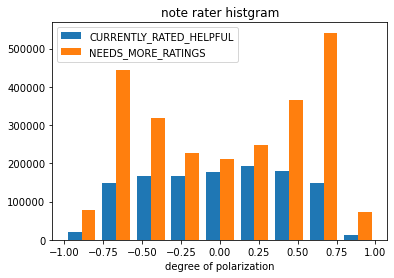

In [105]:
# "CURRENTLY_RATED_HELPFUL", "NEEDS_MORE_RATINGS" になったnoteを評価したuserのfactorの総計ヒストグラム
bins = np.linspace(-1, 1, 10)
helpful_user_factor_arr = np.array(helpful_user_factor)
need_user_factor_arr = np.array(need_user_factor)

plt.hist([helpful_user_factor_arr, need_user_factor_arr], bins, label=["CURRENTLY_RATED_HELPFUL", "NEEDS_MORE_RATINGS"])
plt.legend()
plt.xlabel("degree of polarization")
plt.title("note rater histgram")
plt.savefig("note_rator_histgram_polarization.jpg")

In [71]:
print(f"filteringされたnoteの割合：{np.round(100 * not_factor_note_cnt/ extract_rating_helpful.shape[0], decimals=2)} %")
print(f"filteringされたuserの割合：{np.round(100 * not_factor_user_cnt/ extract_rating_helpful.shape[0], decimals=2)} %")

filteringされたnoteの割合：10.52 %
filteringされたuserの割合：17.52 %


In [94]:
### noteごとの分極度ヒストグラム ###

# raterごとに対象noteが "HELPFUL" か "NEEDS_MORE_RATINGS" か確認
# それぞれの場合でraterのfactor(noteごとにもつfactorに対する反応度→分極度合い)を格納
helpful_user_factor_dict = {}
need_user_factor_dict = {}
not_factor_user_cnt = 0
not_factor_note_cnt = 0

# noteごとにuser_factorを集積
for i, r in enumerate(extract_rating_helpful.itertuples()):
    #print(r[1])
    user_id =  r[2]
    note_id = str(r[1])
    
    if user_id in user_dict:  # factorがつけられたuserのみ抽出(filteringされている)
        if note_id in note_dict: # factorがつけられたnoteのみ抽出(filteringされている)
            if note_dict[note_id] == "CURRENTLY_RATED_HELPFUL":
                #print("CURRENTLY_RATED_HELPFUL")
                if note_id in helpful_user_factor_dict:
                    helpful_user_factor_dict[note_id].append(user_dict[user_id])
                else:
                    helpful_user_factor_dict[note_id] = [user_dict[user_id]]


            elif note_dict[note_id] == "NEEDS_MORE_RATINGS":
                #print("NEEDS_MORE_RATINGS")
                
                if note_id in need_user_factor_dict:
                    need_user_factor_dict[note_id].append(user_dict[user_id])
                else:
                    need_user_factor_dict[note_id] = [user_dict[user_id]]
                
        else:
            not_factor_note_cnt += 1
            
    else:
        not_factor_user_cnt += 1

In [95]:
# noteごとにuser factorの平均・標準偏差を出す
user_factor_per_note = {"mean": {"CURRENTLY_RATED_HELPFUL": [], "NEEDS_MORE_RATINGS": []},
                                            "std": {"CURRENTLY_RATED_HELPFUL": [], "NEEDS_MORE_RATINGS": []}}
for v in helpful_user_factor_dict.values():
    user_factor_per_note["mean"]["CURRENTLY_RATED_HELPFUL"].append(np.mean(v))
    user_factor_per_note["std"]["CURRENTLY_RATED_HELPFUL"].append(np.std(v))   
                                 
for v in need_user_factor_dict.values():
    user_factor_per_note["mean"]["NEEDS_MORE_RATINGS"].append(np.mean(v))
    user_factor_per_note["std"]["NEEDS_MORE_RATINGS"].append(np.std(v))   

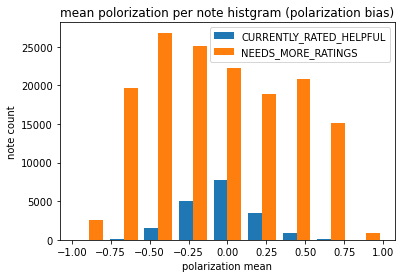

In [104]:
# noteごとの評価したuserのfactorの平均（分極度の偏り）のヒストグラム
# HELPFULなnoteの方が分極度の偏りが小さい

bins = np.linspace(-1, 1, 10)
mean_helpful_arr = np.array(user_factor_per_note["mean"]["CURRENTLY_RATED_HELPFUL"])
mean_need_arr = np.array(user_factor_per_note["mean"]["NEEDS_MORE_RATINGS"])

plt.hist([mean_helpful_arr, mean_need_arr], bins, label=["CURRENTLY_RATED_HELPFUL", "NEEDS_MORE_RATINGS"])
plt.legend()
plt.xlabel("polarization mean")
plt.ylabel("note count")
plt.title("mean polorization per note histgram (polarization bias)")
plt.savefig("figure/mean_polorization_per_note_histgram.jpg")

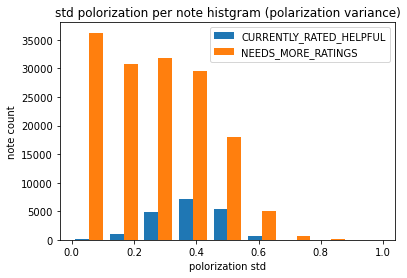

In [103]:
# noteごとの評価したuserのfactorの標準偏差（分極度のばらつき）のヒストグラム
# HELPFULなnoteの方が分極度がばらついている

bins = np.linspace(0, 1, 10)
std_helpful_arr = np.array(user_factor_per_note["std"]["CURRENTLY_RATED_HELPFUL"])
std_need_arr = np.array(user_factor_per_note["std"]["NEEDS_MORE_RATINGS"])

plt.hist([std_helpful_arr, std_need_arr], bins, label=["CURRENTLY_RATED_HELPFUL", "NEEDS_MORE_RATINGS"])
plt.legend()
plt.xlabel("polorization std")
plt.ylabel("note count")
plt.title("std polorization per note histgram (polarization variance)")
plt.savefig("figure/std_polorization_per_note_histgram.jpg")

(array([ 0., 19., 29., 29., 27., 14.,  8.,  7.,  0.]),
 array([-1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
         0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ]),
 <BarContainer object of 9 artists>)

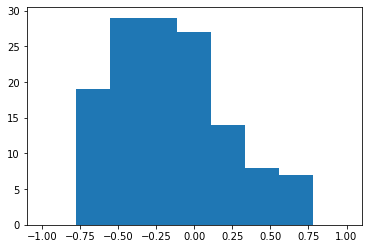

In [79]:
plt.hist(mean_helpful_arr, bins, label="CURRENTLY_RATED_HELPFUL")

In [82]:
print(len(helpful_user_factor_dict.keys()))
print(len(need_user_factor_dict.keys()))

print(len(helpful_user_factor_dict.values()))
print(len(need_user_factor_dict.values()))

print(len(mean_helpful_arr))

19151
163088
19151
163088
19151


In [83]:
mean_helpful_arr

array([        nan,         nan,         nan, ...,  0.56392485,
       -0.43675724, -0.03500327])

In [84]:
helpful_user_factor_dict

{'1377061482198827009': [-0.5326022,
  nan,
  -0.6077558,
  -0.6292715,
  0.14620796,
  0.09054136],
 '1515341852848930817': [-0.5326022,
  -0.6492873,
  -0.8114681,
  nan,
  0.5979085,
  -0.809147,
  -0.5984965,
  -0.8079383,
  nan,
  nan,
  0.12699006,
  nan,
  -0.7240017,
  -0.7295462,
  0.31783774,
  0.042513873,
  -0.7025286,
  -0.80489737,
  -0.7728865],
 '1534746003441590273': [-0.5326022,
  -0.70534295,
  nan,
  -0.71811306,
  0.31746924,
  -0.809147,
  nan,
  0.011545132,
  -0.7726514,
  -0.24602973,
  0.5566369],
 '1537166502390026246': [-0.5326022,
  nan,
  nan,
  -0.43509004,
  -0.6042221,
  -0.73997784,
  0.6861569,
  0.43236035,
  nan,
  nan,
  nan,
  nan,
  -0.40010673,
  0.19222829,
  nan,
  -0.70645124,
  nan,
  -0.79558957,
  nan,
  -0.42477453,
  -0.67309505,
  0.09054136,
  0.65248245,
  nan,
  -0.45562398,
  -0.33360472,
  -0.3383211,
  -0.69236267,
  0.47959268,
  0.47891822,
  nan,
  nan,
  nan,
  -0.4287332,
  0.5566369,
  -0.7728865,
  0.06040456],
 '1538716139

In [87]:
print(helpful_user_factor_dict['1377061482198827009'][1])
print(type(helpful_user_factor_dict['1377061482198827009'][1]))
print(np.isnan(helpful_user_factor_dict['1377061482198827009'][1]))

nan
<class 'float'>
True
